See original notebook : https://drive.google.com/drive/folders/1LQ4IR6SrvPmXch67rHIOUwcZllutVRQZ?usp=sharing

# Fundamental matrix computation for epipolar geometry

The goal of this script is to compute an estimation of the fundamental matrix to encode the epipolar geometry between two images taken from a moving camera

# Imports

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Helper functions

In [23]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color=tuple(cv2.cvtColor(np.asarray([[[np.random.randint(0,180),255,255]]],dtype=np.uint8),cv2.COLOR_HSV2BGR)[0,0,:].tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,2)
        img1 = cv2.circle(img1,(int(pt1[0]), int(pt1[1])),5,color,-1)
        img2 = cv2.circle(img2,(int(pt2[0]), int(pt2[1])),5,color,-1)
    return img1,img2

def drawFundamental(img1,img2,pts1,pts2,F):
    # Find epilines corresponding to some points in right image (second image) and
    # drawing its lines on left image
    indexes = np.random.randint(0, pts1.shape[0], size=(10))
    indexes=range(pts1.shape[0])
    samplePt1 = pts1[indexes,:]
    samplePt2 = pts2[indexes,:]

    lines1 = cv2.computeCorrespondEpilines(samplePt2.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawlines(img1,img2,lines1,samplePt1,samplePt2)

    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(samplePt1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2,img1,lines2,samplePt2,samplePt1)
    return img5, img3

# Dataset loading

In [11]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/Projects_for_Github/Fundamental_matrix_epipolar_geometry"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Projects_for_Github/Fundamental_matrix_epipolar_geometry


In [12]:
input1 = cv2.imread('MultiView/POP01.jpg') #queryimage # left image
input2 = cv2.imread('MultiView/POP02.jpg') #trainimage # right image
#input1 = cv2.imread('MultiView/Corridor/bt.001.pgm')  #queryimage # left image
#input2 = cv2.imread('MultiView/Corridor/bt.002.pgm')  #queryimage # left image
#input1 = cv2.imread('MultiView/Merton1/002.jpg')  #queryimage # left image
#input2 = cv2.imread('MultiView/Merton1/003.jpg')  #queryimage # left image
#input1 = cv2.imread('MultiView/ToyHouse/house.005.pgm')  #queryimage # left image
#input2 = cv2.imread('MultiView/ToyHouse/house.006.pgm')  #queryimage # left image

# Convert to grayscale

In [13]:
img1 =  cv2.cvtColor(input1,cv2.COLOR_BGR2GRAY)
img2 =  cv2.cvtColor(input2,cv2.COLOR_BGR2GRAY)

# Detection of interesting points using KAZE

In [14]:
kaze = cv2.KAZE_create(upright = False,
                      threshold = 0.001,
                      nOctaves = 4,
                      nOctaveLayers = 4,
                      diffusivity = 2)

## Computation of M-SURF descriptors

In [15]:
kp1, des1 = kaze.detectAndCompute(img1,None)
kp2, des2 = kaze.detectAndCompute(img2,None)
print('Nb of KAZE points : ' + str(len(kp1)) + ' (left) ' + str(len(kp2)) + ' (right)')

Nb of KAZE points : 2131 (left) 1588 (right)


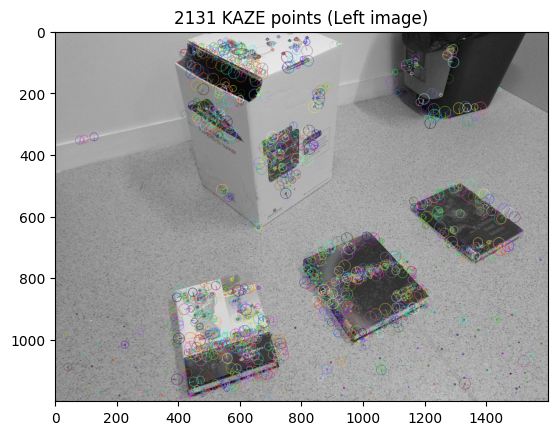

In [16]:
imgd=img1
imgd = cv2.drawKeypoints(img1, kp1, imgd,-1,flags=4)
plt.imshow(imgd),plt.title('%i KAZE points (Left image)'%len(kp1))
plt.show()

Nb of selected pairs : 92


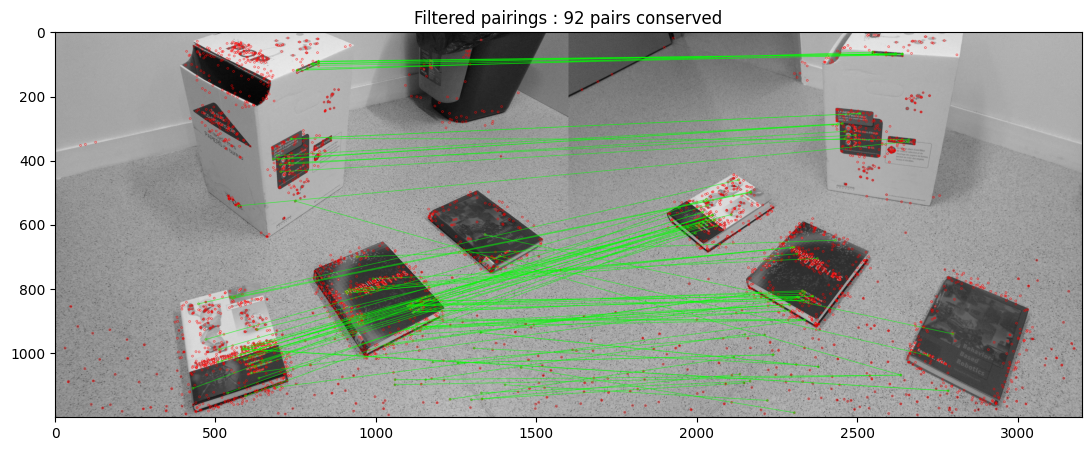

In [17]:
pts1 = []
pts2 = []

# L2 distance for M-SURF descriptors (KAZE)
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
# Extraction of the list of 2 nearest neighbors
matches = bf.knnMatch(des1,des2, k=2)

# Filtering of pairs by applying ratio test
good = []
for m,n in matches:
  if m.distance < 0.7*n.distance:
    pts2.append(kp2[m.trainIdx].pt)
    pts1.append(kp1[m.queryIdx].pt)
    good.append([m])
    
mfilt_image = np.array([])
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   flags = 0)
mfilt_image = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,**draw_params)
pts1 = np.float32(pts1)
pts2 = np.float32(pts2)
print('Nb of selected pairs : ' + str(pts1.shape[0]))

plt.figure(figsize=(15, 5))
plt.imshow(mfilt_image)
plt.title('Filtered pairings : %i pairs conserved' %pts1.shape[0])
plt.show()

# Computation of fundamental matrix with OpenCV and RANSAC

In [18]:
FRansac, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC,
                         ransacReprojThreshold = 0.5, # Max distance for reprojection in pixels for an inlier 
                         confidence = 0.99) # Confidence level desired
print('Nb of inliers in RANSAC : ' + str(mask.sum()))

Nb of inliers in RANSAC : 34


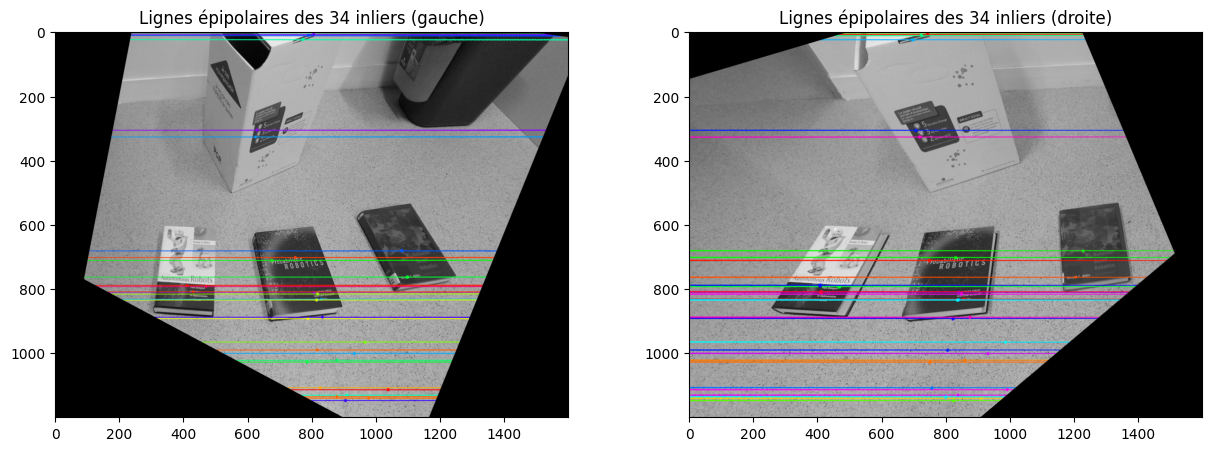

In [24]:
# We show inliers only
inlierpts1 = pts1[mask.ravel()==1]
inlierpts2 = pts2[mask.ravel()==1]

# We recover the images
imgL, imgR = drawFundamental(img1,img2,inlierpts1,inlierpts2,FRansac)

###### Rectification using the two homographies
h, w, _ = imgR.shape

_, H1, H2 = cv2.stereoRectifyUncalibrated(inlierpts1, inlierpts2, FRansac, (w,h)) # Calcul des homographies
imgL2 = cv2.warpPerspective(imgL, H1, (w,h))
imgR2 = cv2.warpPerspective(imgR, H2, (w,h))

# Plot of epipolar lines
plt.figure(figsize=(15, 5))
plt.subplot(121),plt.imshow(imgL2)
plt.title('Lignes épipolaires des %i inliers (gauche)' %mask.sum())
plt.subplot(122),plt.imshow(imgR2)
plt.title('Lignes épipolaires des %i inliers (droite)' %mask.sum())
plt.show()